In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import torch
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Valid.csv
/kaggle/input/Train.csv
/kaggle/input/Test.csv


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Load training, testing, and validation data from CSV files
train_df = pd.read_csv("/kaggle/input/Train.csv")
test_df = pd.read_csv("/kaggle/input/Test.csv")
val_df = pd.read_csv("/kaggle/input/Valid.csv")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
train_df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [6]:
len(train_df),len(test_df),len(val_df)

(40000, 5000, 5000)

In [7]:
train_df["label"].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


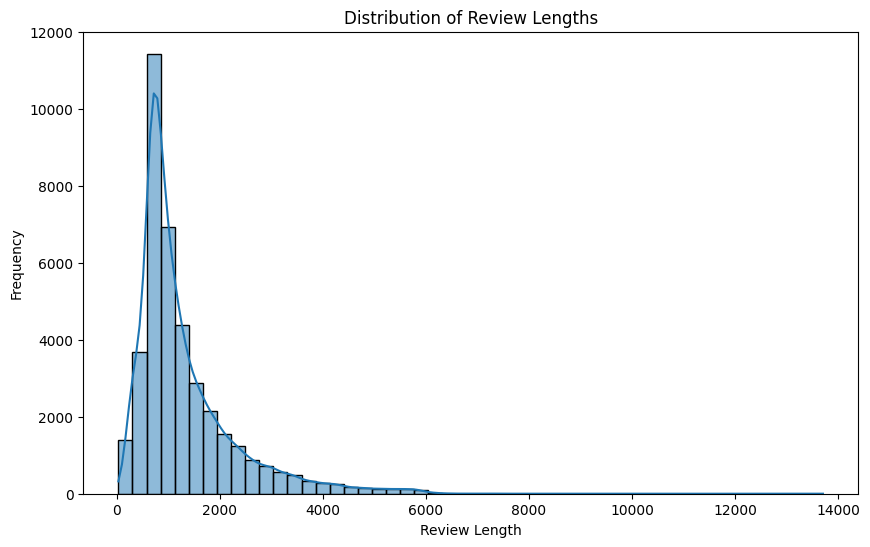

In [8]:
train_df['review_length'] = train_df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

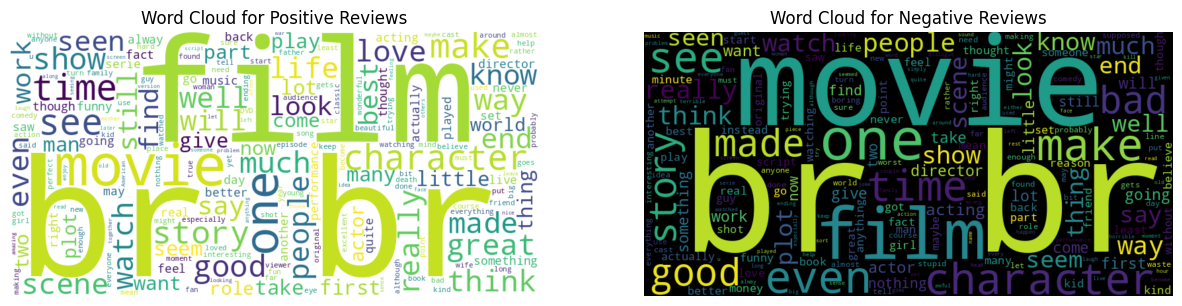

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for positive and negative reviews
positive_reviews = ' '.join(train_df[train_df['label'] == 1]['text'])
negative_reviews = ' '.join(train_df[train_df['label'] == 0]['text'])

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)

# Display the word clouds
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')

plt.show()

In [10]:
train_df=train_df.drop('review_length',axis=1)

In [17]:
from transformers import AutoTokenizer
import torch

def batch_tokenize(texts, tokenizer, batch_size=100):
    input_ids, attention_masks = [], []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        encodings = tokenizer(batch, truncation=True, padding=True, return_tensors='pt')
        input_ids.append(encodings['input_ids'])
        attention_masks.append(encodings['attention_mask'])
    return {
        'input_ids': torch.cat(input_ids, dim=0),
        'attention_mask': torch.cat(attention_masks, dim=0)
    }

# Tokenize in batches
train_texts = list(train_df['text'])
test_texts = list(test_df['text'])
val_texts = list(val_df['text'])

train_encodings = batch_tokenize(train_texts, tokenizer)
test_encodings = batch_tokenize(test_texts, tokenizer)
val_encodings = batch_tokenize(val_texts, tokenizer)

# Create labels
train_labels = torch.tensor(train_df['label'].values)
test_labels = torch.tensor(test_df['label'].values)
val_labels = torch.tensor(val_df['label'].values)

In [18]:
from torch.utils.data import Dataset

class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create dataset objects
train_dataset = IMDbDataset(train_encodings, train_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)

In [19]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Initialize the trainer
trainer = Trainer(
    model=model,  # Assume the model is already defined
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,0.781100
20,0.713200
30,0.702700
40,0.681200
50,0.667100
60,0.652600
70,0.615600
80,0.632900
90,0.566100
100,0.528800


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=7500, training_loss=0.15346767186472812, metrics={'train_runtime': 6777.8363, 'train_samples_per_second': 17.705, 'train_steps_per_second': 1.107, 'total_flos': 3.15733266432e+16, 'train_loss': 0.15346767186472812, 'epoch': 3.0})

In [20]:
model.save_pretrained("/kaggle/working/bert_imdb")

In [22]:
# Evaluate the model
eval_results = trainer.evaluate(test_dataset)

In [23]:
eval_results

{'eval_loss': 0.2542981803417206,
 'eval_runtime': 90.8905,
 'eval_samples_per_second': 55.011,
 'eval_steps_per_second': 3.444,
 'epoch': 3.0}

In [58]:
neg_texts = test_df[test_df["label"] == 0]["text"]
first_neg_text = neg_texts.iloc[0]
print(first_neg_text)

I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily. But then one day a tragic happenstance occurred. After a White Sox game ended I realized that the remote was all the way on the other side of the room somehow. Now I could have just gotten up and walked across the room to get the remote, or even to the TV to turn the channel. But then why not just get up and walk across the country to watch TV in another state? "Nuts to that", I said. So I decided to just hang tight on the couch and take whatever Fate had in store for me. What Fate had in store was an episode of this show, an episode about which I remember very little except that I had once again made a very broad, general sweeping blanket judgment based on zero objective or experiential evidence with nothing whatsoever to back my opinions up with, and once again I was completely right! This show is a total crud-pie! Belushi has all the comedic delivery of a hairy lighthou

In [57]:
positive_texts = test_df[test_df["label"] == 1]["text"]
first_positive_text = positive_texts.iloc[0]
print(first_positive_text)

The most interesting thing about Miryang (Secret Sunshine) is the actors. Jeon Do-yeon, as Lee Shin-ae, the main character, is a woman with a young son whose husband has died in a tragic accident, and who leaves Seoul to live in Miryang, which was his home town, with her young son. Jeon's face is very changeable. She is girlish, flirtatious, elegant, aged and sad, desperate and joyous, with it and terribly isolated by turns, and it's all in her face. The film also stars Song Kang-ho as Kim, a man who meets her when her car breaks down coming into Miryang, who happens to run a garage in town, and who follows her around all the time thereafter, despite her apparent lack of interest in his attentions. Song is the biggest star in Korea right now, renowned for his work with Park Chan-wook and Bong Joon-ho (Sympathy for Mr. Vengeance; Memories of Murder and The Host). And yet here he plays a throwaway character, almost a forgotten man. But of course he makes him interesting and curiously app

In [59]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    return prediction
def main():
    print("Sentiment Analysis CLI")
    while True:
        text = input("Enter your text (or 'exit' to quit): ")
        if text.lower() == "exit":
            break
        else:
            prediction = predict_sentiment(text)
            if prediction == 0:
                print("** Negative **")
            else:
                print("** Positive **")

if __name__ == "__main__":
    main()

Sentiment Analysis CLI


Enter your text (or 'exit' to quit):   always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily. But then one day a tragic happenstance occurred. After a White Sox game ended I realized that the remote was all the way on the other side of the room somehow. Now I could have just gotten up and walked across the room to get the remote, or even to the TV to turn the channel. But then why not just get up and walk across the country to watch TV in another state? "Nuts to that", I said. So I decided to just hang tight on the couch and take whatever Fate had in store for me. What Fate had in store was an episode of this show, an episode about which I remember very little except that I had once again made a very broad, general sweeping blanket judgment based on zero objective or experiential evidence with nothing whatsoever to back my opinions up with, and once again I was completely right! This show is a total crud-pie! Belushi has all the

** Negative **


Enter your text (or 'exit' to quit):  The most interesting thing about Miryang (Secret Sunshine) is the actors. Jeon Do-yeon, as Lee Shin-ae, the main character, is a woman with a young son whose husband has died in a tragic accident, and who leaves Seoul to live in Miryang, which was his home town, with her young son. Jeon's face is very changeable. She is girlish, flirtatious, elegant, aged and sad, desperate and joyous, with it and terribly isolated by turns, and it's all in her face. The film also stars Song Kang-ho as Kim, a man who meets her when her car breaks down coming into Miryang, who happens to run a garage in town, and who follows her around all the time thereafter, despite her apparent lack of interest in his attentions. Song is the biggest star in Korea right now, renowned for his work with Park Chan-wook and Bong Joon-ho (Sympathy for Mr. Vengeance; Memories of Murder and The Host). And yet here he plays a throwaway character, almost a forgotten man. But of course he m

** Positive **


Enter your text (or 'exit' to quit):  exit
